In [ ]:
from pymystem3 import Mystem
import pymorphy2
from pymorphy2 import MorphAnalyzer
import json
import urllib.request
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests 

m = Mystem()


In [2]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

def clean_list (target_list):
    token_list = [' ', ', ', ',', '. ', '.', '?', '!', '? ', '! ', '\n', ' \n', '\n ', '-', ' “','“', '” ', '”', '#', '# ',
                 ' #', ';', ' ;', '; ', ' – ',' –', '– ']
    for i in token_list:
        target_list = remove_values_from_list (target_list, i)
    return target_list

dct = ['поребрик', 'парадка', 'булка', 'кура', 'бадлон']
cities = ['Москва', 'Санкт-Петербург']

In [ ]:
# token request:
# https://oauth.vk.com/authorize?client_id=7234377&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52
url = "https://api.vk.com/method/"
accessToken = "your-token"
version = "5.92"
nPostsMax = 100
nDictPosts = 0

In [ ]:
data = pd.read_csv("data.csv", encoding = "cp1251")

In [ ]:
try:
    userID = max (data['UserID']) + 1
except:
    userID = 1

In [ ]:
# this algorythm analyzes the first 100 posts of 150 not-yet-analyzed VK users and tries to find instances of
# dictionary words in the posts. as a pre-processing step each post text is lemmatized

for i in range (150):

    time.sleep (1) # the system gets angry if the requests are too frequent
    print ('User ID: ' + str (userID))

    # initialize variables
    nPosts = 0
    nDictPosts = 0
    city = ''
    sex = ''
    birthYear = ''
    
    userResp = requests.get(
        url+"users.get",
        params={
            "user_ids": userID,
            "fields": "sex,bdate,city,home_town",
            "v": version,
            "access_token": accessToken
        }
    ).json()

    if 'bdate' in userResp['response'][0].keys():
        birthYear = userResp['response'][0]['bdate'][-4:]
        if float (birthYear) < 1000:
            birthYear = ''
    
    if 'sex' in userResp['response'][0].keys():
        if userResp['response'][0]['sex'] == 2:
               sex = 'Male'
        if userResp['response'][0]['sex'] == 1:
               sex = 'Female'
    
    if 'city' in userResp['response'][0].keys():
        if userResp['response'][0]['city']['title'] in cities:
            
            # if the user is from one of the required cities, get their wall
            city = userResp['response'][0]['city']['title']
            wallReq = urllib.request.Request(url + "wall.get?owner_id=" + str (userID) + "&count=" + str (nPostsMax) +
                                             "&filter=owner" + "&offset=0" +
                                             "&v=" + version + "&access_token=" + accessToken)
            wallResp = urllib.request.urlopen(wallReq)
            wallResp = wallResp.read().decode('utf-8')
            wallResp = json.loads(wallResp)
            
            if 'response' in wallResp.keys():
                if 'count' in wallResp['response'].keys():
                    if wallResp ['response']['count'] > 0:
                        
                        # if there is at least one post, analyze the posts
                        nPosts = min (len(wallResp ['response']['items']), nPostsMax)
                        for i in range (min (len(wallResp ['response']['items']), nPostsMax)):
                            print ('User ID: ' + str (userID) + ', post no. ' + str (i + 1))
                            flag = False
                            if wallResp['response']['items'][i]['text'] == '':
                                nPosts -= 1
                            else:
                                lemmas = m.lemmatize (wallResp['response']['items'][i]['text'].lower())
                                lemmas = clean_list (lemmas)
                                for l in lemmas:
                                    if l in dct:
                                        flag = True
                                        nDictPosts += 1
                                        break
                        
                        # if there are some posts, but they don't contain text, nPosts will be equal to 0
                        # we only need data on posts with texts
                        if nPosts > 0:
                            l = [str(userResp['response'][0]['id']),
                                 city,
                                 sex,
                                 birthYear,
                                 str(nPosts),
                                 str(nDictPosts)]
                            with open('data.csv','a') as fd:
                                fd.write(','.join(l))
                                fd.write('\n')
    userID += 1

print ('Done!')

/home/dkbrz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/dkbrz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


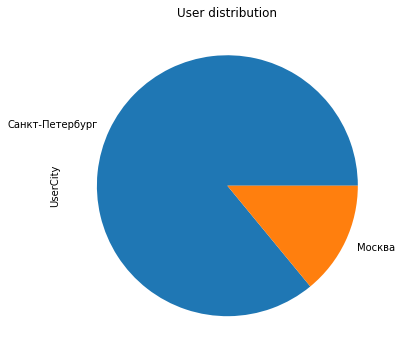

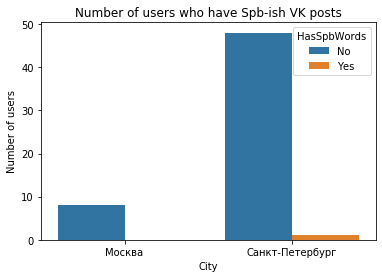

In [5]:
data = pd.read_csv("data.csv", encoding = "cp1251")

data['HasSpbWords'] = ''

data['HasSpbWords'][data['nSpbPosts'] == 0] = 'No'
data['HasSpbWords'][data['nSpbPosts'] > 0] = 'Yes'

plt.figure(figsize=(6, 6))
data['UserCity'].value_counts().plot(kind = 'pie');
plt.title('User distribution');
plt.show()

df = data.groupby (['UserCity', 'HasSpbWords'], as_index = False).count ()[['UserCity', 'HasSpbWords', 'UserID']]
df.columns = ['City', 'HasSpbWords', 'Count']

sns.barplot (x = 'City', y = 'Count', hue = 'HasSpbWords', data = df)
plt.title('Number of users who have Spb-ish VK posts');
plt.xlabel('City');
plt.ylabel('Number of users');
plt.show()